In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch
torch.manual_seed(0)
torch.cuda.empty_cache()

In [2]:
random_transforms = [transforms.RandomRotation(degrees=5)]

"""train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomCrop(118),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomApply(random_transforms, p=0.2),
    transforms.RandomAffine(0, translate=(0.02,0.02), scale=None, shear=None, resample=False, fillcolor=0),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.02, 0.06), ratio=(0.8, 0.8)),
    transforms.Normalize([0.1307], [0.3081]),
])"""
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomCrop(120),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomApply(random_transforms, p=0.2),
    #transforms.RandomAffine(0, translate=(0.02,0.02), scale=None, shear=None, resample=False, fillcolor=0),
    transforms.ToTensor(),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.RandomErasing(scale=(0.00, 0.01), ratio=(0.6, 0.8)),
    transforms.Normalize([0.1307], [0.3081]),
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])


class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, idx = None):
        self.data = data
        self.targets = labels
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.astype('uint8'), mode='L')

        if self.transform is not None:
           img = self.transform(img)

        return img, target

In [3]:
from sklearn.model_selection import train_test_split

batch_size = 128 #feel free to change it

data = pickle.load(open('../input/ecse-551-f20-image-understanding/Train.pkl', 'rb' ), encoding='bytes')
targets = np.genfromtxt('../input/ecse-551-f20-image-understanding/TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]

#X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.001, random_state=42)

X_train, y_train = data, targets

orig_train_dataset = MyDataset(X_train, y_train, transform=train_transform, idx=None)
#orig_test_dataset = MyDataset(X_test, y_test, transform=test_transform, idx=None)


train_dataset = DataLoader(orig_train_dataset, batch_size=batch_size, shuffle=True)
#test_dataset = DataLoader(orig_test_dataset, batch_size=batch_size, shuffle=False)

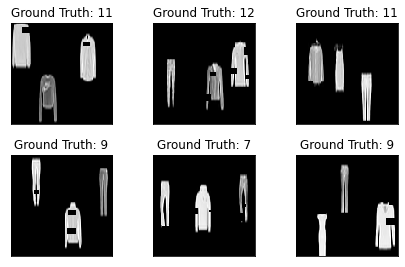

In [4]:
import matplotlib.pyplot as plt


examples = enumerate(train_dataset)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
from typing import Type, Any, Callable, Union, List, Optional
from torch import Tensor

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 9,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

network = wide_resnet50_2().to(device)
criterion = nn.CrossEntropyLoss().to(device)

print(network)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_dataset.dataset) for i in range(3)]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [8]:
#network.load_state_dict(torch.load('../input/wresnet/model_resnet.pth'))
#optimizer.load_state_dict(torch.load('/kaggle/working/optimizer_resnet.pth'))
network = torch.load('../input/wide-resnet-99766/model_last.pth')

In [9]:
optimizer = optim.Adam(network.parameters(), lr=0.0001)

def train(epoch):
  network.train()
  correct = 0
  for batch_idx, (data, label) in enumerate(train_dataset):
        
    data = data.to(device)
    target = (label - 5).to(device)

    optimizer.zero_grad()
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
    loss = criterion(output, target) #negative log liklhood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 20 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_dataset.dataset),
        100. * batch_idx / len(train_dataset), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_dataset.dataset)))
      torch.save(network.state_dict(), '/kaggle/working/model_resnet.pth')
      torch.save(optimizer.state_dict(), '/kaggle/working/optimizer_resnet.pth')
    
  print('\nTraining set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct, len(train_dataset.dataset),
    100. * correct / len(train_dataset.dataset)))

def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_dataset:
        data = data.to(device)
        target = (label - 5).to(device)
        output = network(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        #break
        
  test_loss /= len(test_dataset.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( 
    test_loss, correct, len(test_dataset.dataset),
    100. * correct / len(test_dataset.dataset))) 

In [10]:
for epoch in range(1, 50):
  train(epoch)
  #test()
  if(epoch % 10 == 0):
    torch.save(network, '/kaggle/working/model_wresnet.pth')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.004933
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.123333
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.017760
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.037731
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.013941
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.091891
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.015282
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.034687
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.008672
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.014512
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.012433
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.015111
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.041941
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.027164
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.066303
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.076383
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.054135
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.014485
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.044421
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.019902
Train Epoc

In [11]:
"""y_true = []
y_pred = []

data_mis = []

def test_conf():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for inp, label in test_dataset:
        data = inp.to(device)
        target = (label - 5).to(device)
        output = network(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1].flatten()
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        y_true.append(target.cpu().numpy())
        y_pred.append(pred.cpu().numpy())
        
        idxs_mask = ((pred == target) == False).nonzero()
        if(len(idxs_mask) != 0):
            data_mis.append(inp[idxs_mask].numpy())
        
  test_loss /= len(test_dataset.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( 
    test_loss, correct, len(test_dataset.dataset),
    100. * correct / len(test_dataset.dataset))) 

test_conf()
from sklearn.metrics import confusion_matrix, classification_report
y_true = np.concatenate(np.squeeze(y_true)).ravel()
y_pred = np.concatenate(np.squeeze(y_pred)).ravel()
print(classification_report(y_true, y_pred))"""

"y_true = []\ny_pred = []\n\ndata_mis = []\n\ndef test_conf():\n  network.eval()\n  test_loss = 0\n  correct = 0\n  with torch.no_grad():\n    for inp, label in test_dataset:\n        data = inp.to(device)\n        target = (label - 5).to(device)\n        output = network(data)\n        test_loss += criterion(output, target).item()\n        pred = output.data.max(1, keepdim=True)[1].flatten()\n        correct += pred.eq(target.data.view_as(pred)).sum()\n        \n        y_true.append(target.cpu().numpy())\n        y_pred.append(pred.cpu().numpy())\n        \n        idxs_mask = ((pred == target) == False).nonzero()\n        if(len(idxs_mask) != 0):\n            data_mis.append(inp[idxs_mask].numpy())\n        \n  test_loss /= len(test_dataset.dataset)\n  test_losses.append(test_loss)\n  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format( \n    test_loss, correct, len(test_dataset.dataset),\n    100. * correct / len(test_dataset.dataset))) \n\ntest_conf()\nfrom s

In [12]:
"""import matplotlib.pyplot as plt


fig = plt.figure(figsize=(20, 20))
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(data_mis[i][0][0][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])"""

'import matplotlib.pyplot as plt\n\n\nfig = plt.figure(figsize=(20, 20))\nfor i in range(12):\n  plt.subplot(3,4,i+1)\n  plt.tight_layout()\n  plt.imshow(data_mis[i][0][0][0], cmap=\'gray\', interpolation=\'none\')\n  plt.title("Ground Truth: {}".format(example_targets[i]))\n  plt.xticks([])\n  plt.yticks([])'

In [13]:
#torch.save(network, '/kaggle/working/model_wide_resnet_99.pth')
torch.save(network, '/kaggle/working/model_wresnet_final.pth')
#network = torch.load('/kaggle/working/model_resnet_99.pth')

In [14]:
#network = torch.load('../input/resnet-100/model_resnet_99 (4).pth')

In [15]:
data = pickle.load(open('../input/ecse-551-f20-image-understanding/Test.pkl', 'rb' ), encoding='bytes')

sub_dataset = MyDataset(data, np.zeros((len(data), 1)), transform=test_transform, idx=None)
sub_dataset = DataLoader(sub_dataset, batch_size=batch_size, shuffle=False)

In [16]:
def predict():
  predictions = []
  network.eval()
  with torch.no_grad():
    for data, target in sub_dataset:
        data = data.to(device)
        target = target.to(device)
        target = network(data)
        target = target.data.max(1, keepdim=True)[1].cpu().numpy() + 5
        predictions = np.append(predictions, target)
  return predictions
        
predictions = predict()

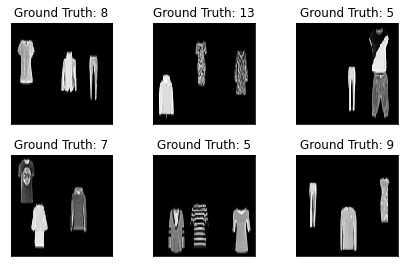

In [17]:
predict_dataset = MyDataset(data, predictions, transform=test_transform, idx=None)
predict_dataset = DataLoader(predict_dataset, batch_size=batch_size, shuffle=False)

examples = enumerate(predict_dataset)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [18]:
print(predictions)

[ 8. 13.  5. ... 10. 10. 12.]


In [19]:
import pandas as pd 
pd.DataFrame(predictions.astype(int)).to_csv('./output.csv', header=['class'])